In [1]:
# Centralized imports of our libraries 
# Always run first to ensure references function

# built functions to load or interact over HTTP with external resources
import requests
import os

# data access and manipulation libraries
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#visualization libraries - ui interaction
import panel as pn
import ipywidgets as widgets
from IPython.display import display


In [2]:

# load the datat from the stored assets 
# reusable function to load a pandas dataframe from an existing csv file

def download_chicago_crashdata(filepath:str='assets/data/chicago_traffic_crashes.csv')->bool:

    """
    Downloads the Chicago crash data from the public site and stores it in the provided filepath.
    Args:
        filepath (str): File where to store the downloaded data
    Returns:
        None
    """
    url = 'https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv?fourfour=85ca-t3if&cacheBust=1742398767&date=20250319&accessType=DOWNLOAD'
    
    # only delete the file on force and it exists
    if os.path.exists(filepath):
        try:
            os.remove(filepath)
            print(f"Existing file {filepath} deleted.")
        except OSError as e:
            print(f"Error deleting existing file: {e}")
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        with open(filepath, 'wb') as f:
            f.write(response.content)
        print(f"CSV saved to {filepath}")
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error fetching or saving CSV: {e}")
    except IOError as e:
        print(f"Error writing to file: {e}")
    # catch all - something failed :-(    
    return False
        
    
def get_chicago_crash_data(filepath:str='assets/data/chicago_traffic_crashes.csv')->pd.DataFrame:
    """
    Gets a CSV dataset via the url
    Args:

        filepath (str): The path to save the CSV file.
    Returns:
        A pandas DataFrame containing the CSV file content
    """

    # if the file does exist locally - we will go grab it
    if os.path.exists(filepath):
        try:
            return etl_crash_data(pd.read_csv(filepath))
        except Exception as e:
            print(f"Error loading the CSV: {e}")
            return None

    # not force and the file is already there - voila
    print(f"No file called::{filepath} found")
    return None


def etl_crash_data(df:pd.DataFrame)->pd.DataFrame:
    """
    Does some transformation and extraction of additional data into our crash dataset that can be helpful calculating visualization
    Args:

        df (pandas dataframe): Dataframe to modify and pass back to the caller
    Returns:
        A modified dataframe with some additional enriched data.
    """

    # call out why this is important - pass in the format - faster to load seconds over minutes.
    df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'],format="%m/%d/%Y %I:%M:%S %p")
    df['CRASH_YEAR'] = df['CRASH_DATE'].dt.year
    df['CRASH_YEAR'] = df['CRASH_DATE'].dt.year
    df['CRASH_DAY_NAME'] = df['CRASH_DATE'] .dt.day_name()
    df['CRASH_MONTH_NAME'] = df['CRASH_DATE'].dt.month_name()

    # we want to insure our numeric data is properly set to 0 where NaN is encountered
    df['INJURIES_TOTAL'] = df['INJURIES_TOTAL'].fillna(0)
    df['INJURIES_FATAL'] = df['INJURIES_FATAL'].fillna(0)
    df['INJURIES_INCAPACITATING'] = df['INJURIES_INCAPACITATING'].fillna(0)
    df['INJURIES_NO_INDICATION'] = df['INJURIES_NO_INDICATION'].fillna(0)
    df['INJURIES_NON_INCAPACITATING'] = df['INJURIES_NON_INCAPACITATING'].fillna(0)
    df['INJURIES_UNKNOWN'] = df['INJURIES_UNKNOWN'].fillna(0)
    df['INJURIES_REPORTED_NOT_EVIDENT'] = df['INJURIES_REPORTED_NOT_EVIDENT'].fillna(0)

    return df


In [3]:
df = get_chicago_crash_data('assets/data/chicago_traffic_crashes.csv')
df.head(10)


,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR,CRASH_DAY_NAME,CRASH_MONTH_NAME
0,00a530520c84927490b597a6220ff3f2a3347472ef3086...,NaN,2025-01-15 13:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,RAMP,...,0.0,13,4,1,41.816073,-87.656743,POINT (-87.656742699936 41.816073475493),2025,Wednesday,January
1,00c996c2b04c2d3b5a5fc96d35b2b538e2c0f34703b885...,NaN,2023-07-15 23:00:00,15,NO CONTROLS,NO CONTROLS,UNKNOWN,"DARKNESS, LIGHTED ROAD",REAR TO SIDE,PARKING LOT,...,0.0,23,7,7,41.758974,-87.577299,POINT (-87.577299189217 41.758973539258),2023,Saturday,July
2,027187f52f9cac9ec542f1dda3a9ca8804db1fc2d2a386...,NaN,2020-05-31 01:13:00,30,TRAFFIC SIGNAL,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,...,0.0,1,1,5,41.878326,-87.701280,POINT (-87.701279794376 41.878326229569),2020,Sunday,May
3,204c3ca48ff3cdf0737e7f10b54ef5f8c49fbe30b5e53e...,NaN,2024-12-04 17:39:00,30,UNKNOWN,UNKNOWN,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,0.0,17,4,12,NaN,NaN,NaN,2024,Wednesday,December
4,0235f4b4460f50115c7f6cb0d2bedeea7ce92b9b0f5943...,NaN,2025-01-15 18:40:00,25,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,...,0.0,18,4,1,41.846038,-87.724761,POINT (-87.724761370522 41.846037568964),2025,Wednesday,January
5,1b6c82c982bb0d01618cad1f4703403371cf19eb568dd2...,NaN,2024-11-16 20:50:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,...,0.0,20,7,11,NaN,NaN,NaN,2024,Saturday,November
6,2da86e05a9bff3e60a3f568796c4426b593abb16ef3ef0...,NaN,2024-04-18 17:10:00,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,...,0.0,17,5,4,NaN,NaN,NaN,2024,Thursday,April
7,03638af46c401466857cc6f4038eb6c992ede57917393f...,NaN,2025-01-15 09:57:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,...,0.0,9,4,1,41.967763,-87.760295,POINT (-87.760294815479 41.967763049214),2025,Wednesday,January
8,104b8f542736bba460792745535c857a63b6523cb040c5...,NaN,2025-02-23 21:20:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,FOUR WAY,...,0.0,21,1,2,41.946521,-87.707870,POINT (-87.707870448595 41.946520532996),2025,Sunday,February
9,04716502690d17e32815b04a038533b93e20290adf790f...,NaN,2025-01-15 19:30:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,0.0,19,4,1,41.829775,-87.704754,POINT (-87.704753514706 41.829774959784),2025,Wednesday,January


In [5]:
# Visualizations crash count by year
# As the city of Chicago grows and now is the 3rd largest population, car crashes should grow 


# Our prebuilt dataframe (df) has already gone through some enhancements to ensure:
# - CRASH_DATE is a datetime field
# - CRASH_YEAR is seeded from the year value of th CRASH_DATE
def plot_crash_count_by_year(df:pd.DataFrame):
    """
    Displays the crash count by year from the given dataset and overlays a distribution line.

    Args:
        df (pd.DataFrame): The crash dataset as a Pandas DataFrame.
                           It should contain a 'CRASH_DATE' column with datetime information.
    """
    # Count the number of crashes for each year
    crash_counts_by_year = df['CRASH_YEAR'].value_counts().sort_index()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    crash_counts_by_year.plot(kind='bar', color='skyblue')

    # Overlay a distribution line (Kernel Density Estimate)
    sns.kdeplot(df['CRASH_YEAR'], color='red', linewidth=2)

    # Add labels and title
    plt.xlabel("Year")
    plt.ylabel("Crash Count")
    plt.title("Crash Count by Year with Distribution")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

    # Display the plot
    plt.show()


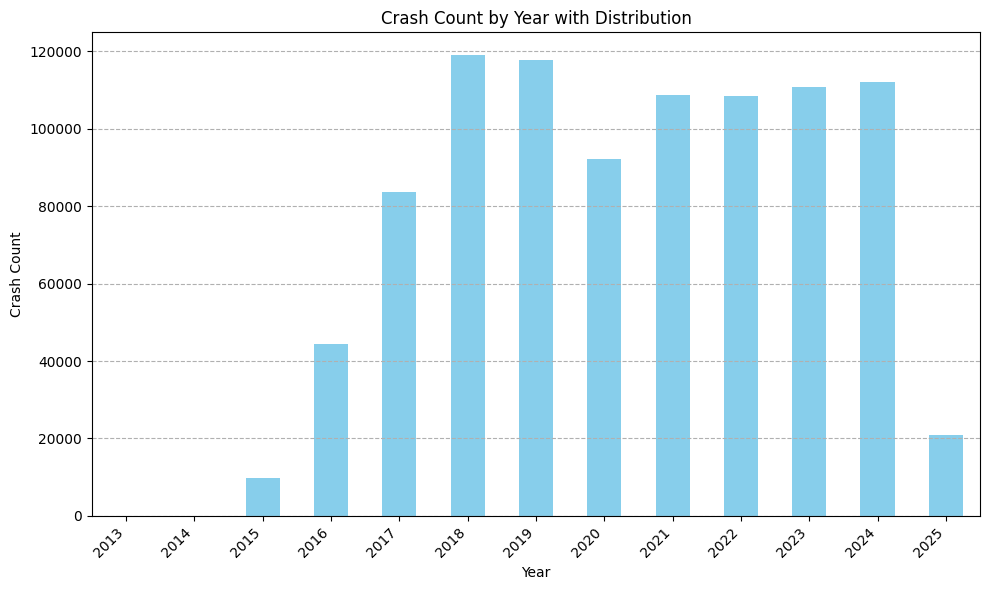

In [6]:
# now lets use our reusable function visualize crash counts by year in the city of Chicago
plot_crash_count_by_year(df)

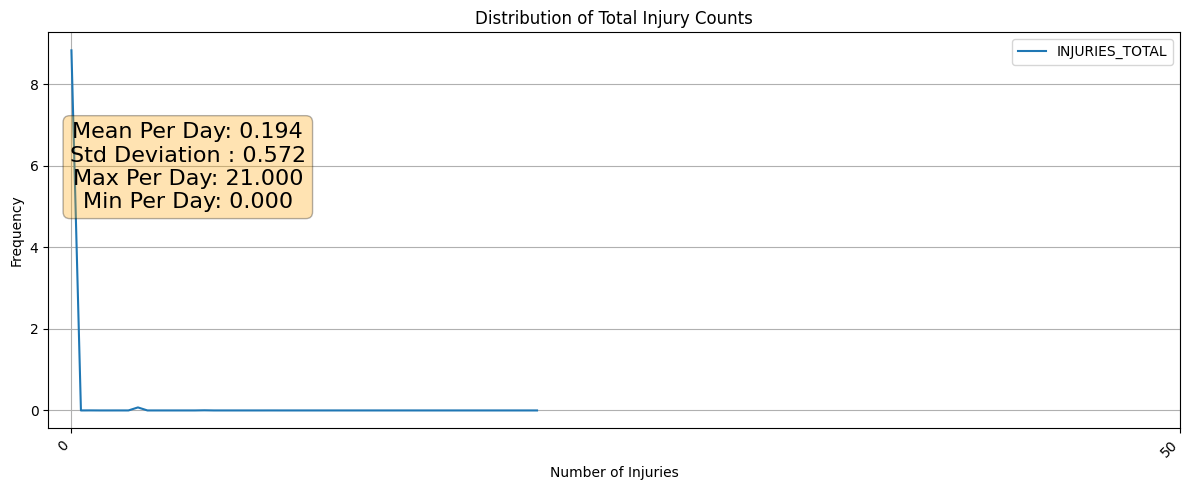

In [7]:

def create_total_injuries_histogram(df:pd.DataFrame):
    """
    Generates a histogram to visualize the distribution of violation counts.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        violations_col (str, optional): The name of the column containing violation counts. Defaults to 'VIOLATIONS'.

    Returns:
        None: Displays the histogram.
    """
    min_val = df['INJURIES_TOTAL'].min()
    max_val = df['INJURIES_TOTAL'].max()

    plt.figure(figsize=(12, 5))  # Adjust figure size as needed

    # Create the histogram
    xgrpvalues = np.linspace(start=min_val, stop=max_val)
    kde = gaussian_kde(df['INJURIES_TOTAL'], bw_method='silverman')
    ykdevalues = kde(xgrpvalues)
    plt.plot(xgrpvalues, ykdevalues, label='INJURIES_TOTAL')

    # Get the range of violation values
    min_violations = df['INJURIES_TOTAL'].min()
    max_violations = df['INJURIES_TOTAL'].max()

    # Determine the start and end points for the ticks with increments of 20
    start_tick = (min_violations // 50) * 50
    end_tick = ((max_violations + 49) // 50) * 50  # Ensure the last tick is at or above the max

    # Create a list of tick values with increments of 50
    tick_values = np.arange(start_tick, end_tick + 1, 50)

    txtdata = []
    txtdata.append(f"Mean Per Day: {df['INJURIES_TOTAL'].mean():.3f}")
    txtdata.append(f"Std Deviation : {df['INJURIES_TOTAL'].std():.3f}")
    txtdata.append(f"Max Per Day: {df['INJURIES_TOTAL'].max():.3f}")
    txtdata.append(f"Min Per Day: {df['INJURIES_TOTAL'].min():.3f}")

    props = dict(boxstyle='round', facecolor='orange', alpha=0.3)
    textstr = '\n'.join(txtdata)
    # 0.2 -> 0.1 = pulling along the x to the left
    # 0.01->0.00 = pulling it down along the y

    # use that GCA!
    ax = plt.gca()
    ax_xmin, ax_xmax = ax.get_xlim()
    ax_ymin, ax_ymax = ax.get_ylim()
    text_x = (ax_xmin + ax_xmax) / 2
    text_y = ax_ymax * 1.05  # Position slightly above the top
    plt.text(text_x/2, text_y/2, textstr, ha='center', va='bottom',fontsize=16, bbox=props)

    #plt.text(0.2, 0.05, textstr, ha="center", fontsize=10, bbox=props)

    # Explicitly set x-axis ticks with values
    plt.xticks(tick_values, rotation=45, ha='right')
    plt.title("Distribution of Total Injury Counts")
    plt.xlabel("Number of Injuries")
    plt.ylabel("Frequency")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

create_total_injuries_histogram(df)

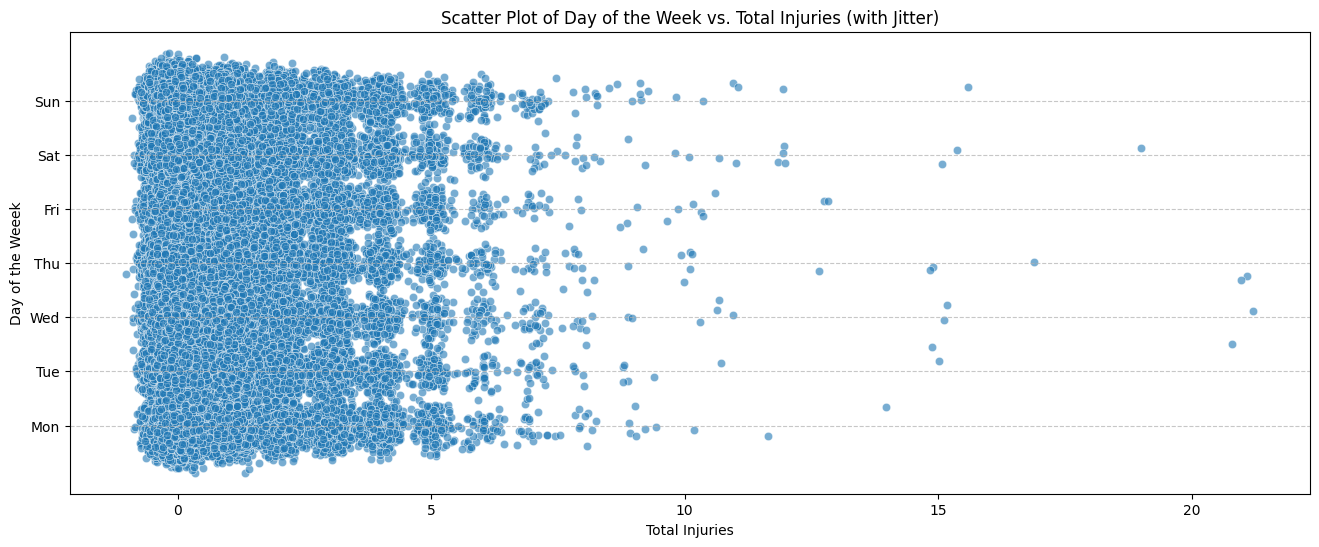

In [8]:
# what posted speed limit produces the most fatal injuries

def plot_crash_day_of_week_vs_injuries_with_jitter(df: pd.DataFrame):
    """
    Generates a scatter plot of 'LANE_CNT' against 'INJURIES_TOTAL'
    from the input pandas DataFrame, with added jitter.

    Args:
        df: The pandas DataFrame containing crash data with
            'CRASH_DAY_OF_WEEK' and 'INJURIES_TOTAL' columns.
    """
    if 'CRASH_DAY_OF_WEEK' not in df.columns or 'INJURIES_TOTAL' not in df.columns:
        print("Error: DataFrame must contain 'CRASH_DAY_OF_WEEK' and 'INJURIES_TOTAL' columns.")
        return

    # Define the amount of jitter
    jitter = 0.2

    # Apply jitter to the 'LANE_CNT' and 'INJURIES_TOTAL' columns
    jittered_x = df['INJURIES_TOTAL'] + np.random.normal(loc=0, scale=jitter, size=len(df))
    jittered_y = df['CRASH_DAY_OF_WEEK'] + np.random.normal(loc=0, scale=jitter, size=len(df))


     # Adjust this value to control the amount of jitter
    plt.figure(figsize=(16, 6))
    sns.scatterplot(x=jittered_x, y=jittered_y, data=df, alpha=0.6)

    plt.yticks(np.arange(1,8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) # Label y-axis with day names
    plt.ylabel('Day of the Weeek')
    plt.xlabel('Total Injuries')

    plt.title('Scatter Plot of Day of the Week vs. Total Injuries (with Jitter)')
    plt.grid(True, which="major", axis="y", linestyle='--', alpha=0.7) # Add a horizontal grid for days
    plt.show()


plot_crash_day_of_week_vs_injuries_with_jitter(df)

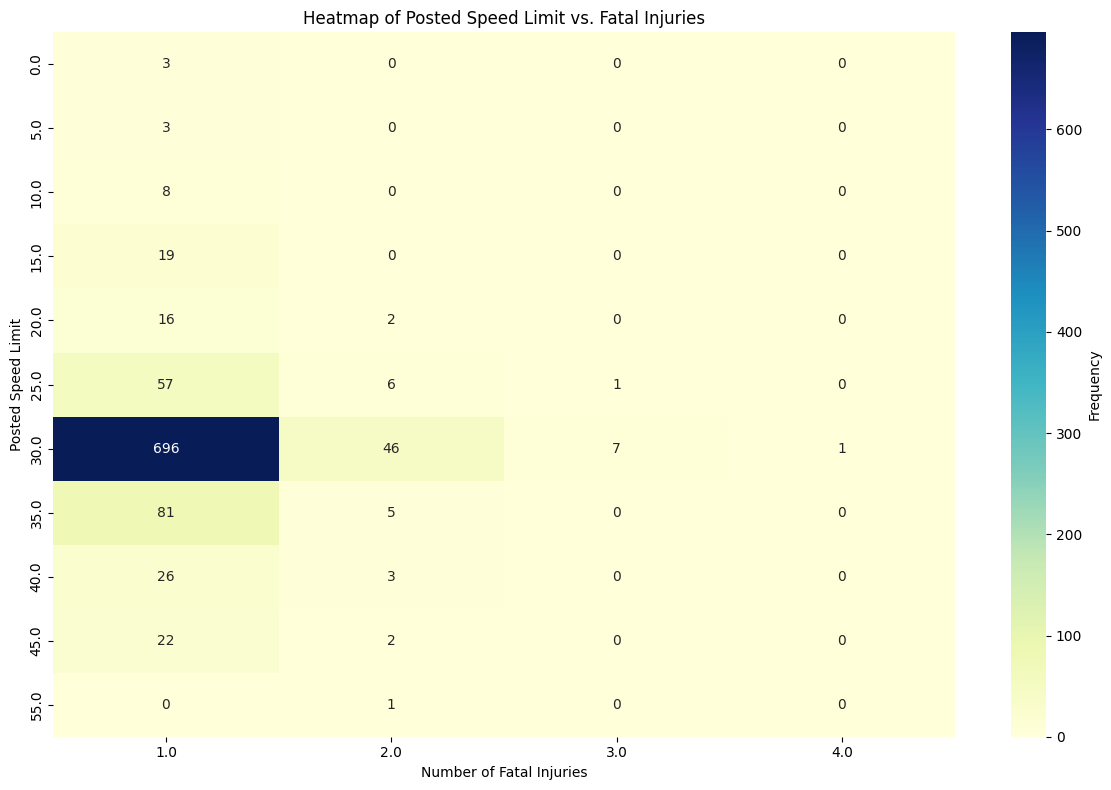

In [9]:
# does speed posted speed a

def plot_heatmap_speed_limit_vs_fatal_injuries(df: pd.DataFrame):
    """
    Generates a heatmap showing the frequency of combinations
    of 'POSTED_SPEED_LIMIT' and 'INJURIES_FATAL' from the input DataFrame.

    Args:
        df: The pandas DataFrame containing crash data with
            'POSTED_SPEED_LIMIT' and 'INJURIES_FATAL' columns.
    """
    if 'POSTED_SPEED_LIMIT' not in df.columns or 'INJURIES_FATAL' not in df.columns:
        print("Error: DataFrame must contain 'POSTED_SPEED_LIMIT' and 'INJURIES_FATAL' columns.")
        return

    df_copy = df.copy()
    df_copy = df_copy.where(df_copy['INJURIES_FATAL'].notnull(), 0).where(df_copy['INJURIES_FATAL'] >0)
    # Create a contingency table (frequency count) of the two columns
    cross_tab = pd.crosstab(df_copy['POSTED_SPEED_LIMIT'], df_copy['INJURIES_FATAL'])

    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
    plt.xlabel('Number of Fatal Injuries')
    plt.ylabel('Posted Speed Limit')
    plt.title('Heatmap of Posted Speed Limit vs. Fatal Injuries')
    plt.tight_layout()
    plt.show()

plot_heatmap_speed_limit_vs_fatal_injuries(df)

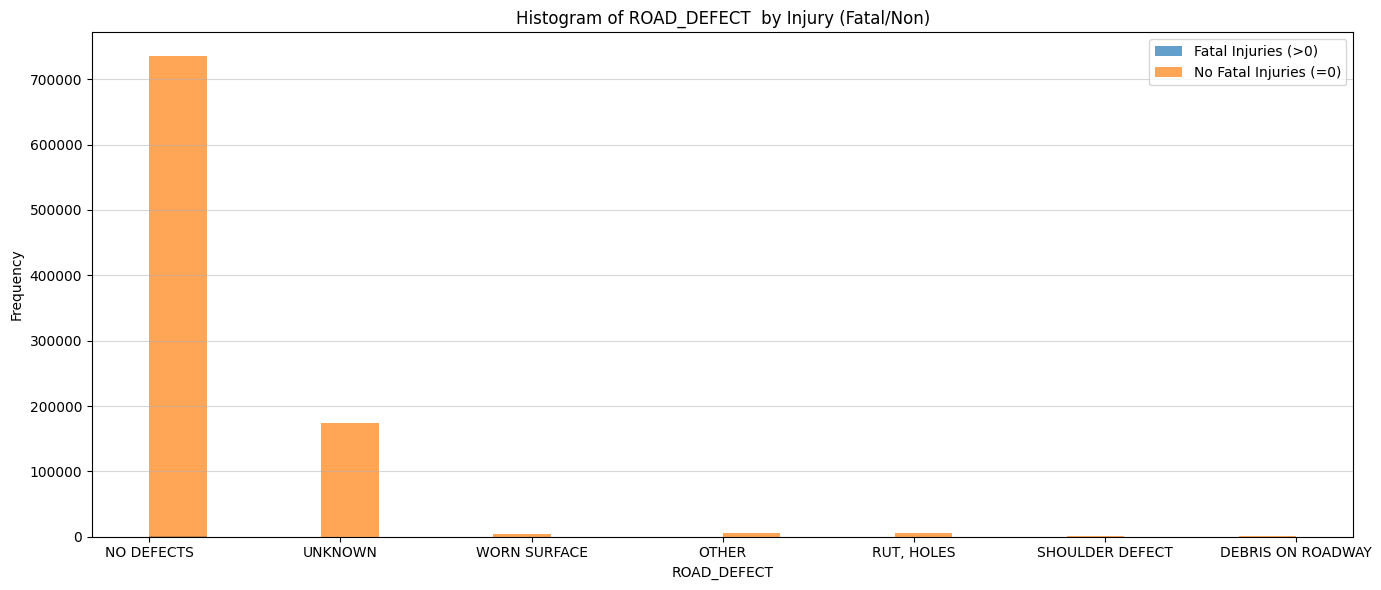

In [10]:
# fatal vs non fatal

def plot_fatal_injuries_histogram(df: pd.DataFrame):
    """
    Generates a histogram comparing the distribution of a chosen variable
    for crashes with fatal injuries (INJURIES_FATAL > 0) versus
    crashes with no fatal injuries (INJURIES_FATAL == 0).

    Args:
        df: The pandas DataFrame containing crash data with
            'INJURIES_FATAL' and other relevant columns.
    """
    if 'INJURIES_FATAL' not in df.columns:
        print("Error: DataFrame must contain 'INJURIES_FATAL' column.")
        return

    fatal_injuries = df[df['INJURIES_FATAL'] > 0]
    no_fatal_injuries = df[df['INJURIES_FATAL'] == 0]

    #
    column_to_compare = 'ROAD_DEFECT'

    if column_to_compare not in df.columns:
        print(f"Error: DataFrame must contain '{column_to_compare}' column.")
        return

    plt.figure(figsize=(14, 6))

    # Histogram for crashes with fatal injuries
    plt.hist(fatal_injuries[column_to_compare], bins=20, alpha=0.7, label='Fatal Injuries (>0)')

    # Histogram for crashes with no fatal injuries
    plt.hist(no_fatal_injuries[column_to_compare], bins=20, alpha=0.7, label='No Fatal Injuries (=0)')

    plt.xlabel(column_to_compare)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_to_compare}  by Injury (Fatal/Non)')
    plt.legend(loc='best')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_fatal_injuries_histogram(df)

In [ ]:
# let's understand how the weather conditions and the road conditions relate.

def plot_frequency_heatmap_weather_road_condition(df: pd.DataFrame):
    """
    Generates a frequency heatmap of 'WEATHER_CONDITION' vs.
    'ROADWAY_SURFACE_COND' from the input DataFrame.

    Args:
        df: The pandas DataFrame containing crash data with
            'WEATHER_CONDITION' and 'ROADWAY_SURFACE_COND' columns.
    """
    if 'WEATHER_CONDITION' not in df.columns or 'ROADWAY_SURFACE_COND' not in df.columns:
        print("Error: DataFrame must contain 'WEATHER_CONDITION' and 'ROADWAY_SURFACE_COND' columns.")
        return

    # Create a contingency table (frequency count) of the two columns
    cross_tab = pd.crosstab(df['WEATHER_CONDITION'], df['ROADWAY_SURFACE_COND'])

    plt.figure(figsize=(12, 10))
    sns.heatmap(cross_tab, annot=True, fmt="d", cmap="viridis", cbar_kws={'label': 'Frequency'})
    plt.xlabel('Roadway Surface Condition')
    plt.ylabel('Weather Condition')
    plt.title('Frequency Heatmap of Weather Condition vs. Roadway Surface Condition')
    plt.tight_layout()
    plt.show()

plot_frequency_heatmap_weather_road_condition(df)

In [32]:
# let's understand via the violin plot

def plot_violinplot_injuries_by_lighting(df: pd.DataFrame,year:int=2025,applylogtransform:bool=True):
    """
    Generates a violin plot of 'INJURIES_TOTAL' for different
    'LIGHTING_CONDITION' categories from the input DataFrame.

    Args:
        df (pd.DataFrame): The pandas DataFrame containing crash data with
            'INJURIES_TOTAL' and 'LIGHTING_CONDITION' columns.
        year (int): The year we want to filter on, we will default to 2025
        applylogtranform (bool): The year we want to filter on, we will default to 2025
    """
    if 'INJURIES_TOTAL' not in df.columns or 'LIGHTING_CONDITION' not in df.columns:
        print("Error: DataFrame must contain 'INJURIES_TOTAL' and 'LIGHTING_CONDITION' columns.")
        return

    plt.figure(figsize=(12, 8))
    df_copy = df.copy()
    df_copy = df_copy[df_copy['CRASH_YEAR']==year]

    if applylogtransform==True:
        # due to a large number of lower number of total injuries, the data is heavily skewed
        # applying a log transform to stretch out the data
        df_copy['LOG_INJURIES_TOTAL'] = np.log(df_copy['INJURIES_TOTAL']+1)
        sns.violinplot(x='LIGHTING_CONDITION', y='LOG_INJURIES_TOTAL', data=df_copy)
        plt.ylabel('Total Injuries - (LOG Transformed)')
    else:
        sns.violinplot(x='LIGHTING_CONDITION', y='INJURIES_TOTAL', data=df_copy)
        plt.ylabel('Total Injuries')
    
    plt.xlabel('Lighting Condition')
    plt.title(f'Violin Plot of Total Injuries by Lighting Condition -{year}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


def setup_interactive_violin():

    """
    Setup for the 
    """
    
    # we need to activate the widgets
    pn.extension('ipywidgets')

    # unique set of years reverse sorted
    years = sorted(df['CRASH_YEAR'].unique(),reverse=True)
    
    #*********************************************
    # setup a dropdown widget bound to the unique
    # default to the most current year
    #*********************************************
    yearselector = widgets.Dropdown(
        options=years,
        value=years[0],
        description='Select a year:',
        disabled=False,
    )
    
    #**************************************************************************************
    #setup a check option to allow the user to see the data with or without a log transform
    #**************************************************************************************
    logtransform = widgets.Checkbox(
        value=False,
        description='Perform Log Transform',
        disabled=False
    )
    
    # our callback function as the widget set is being interacted with
    def crash_year_plot(year,applylogtransform):
        display(plot_violinplot_injuries_by_lighting(df,year,applylogtransform))
        
    # here we will create a panel row and apply Markdown # to create a title and our widgets
    row = pn.Row('# Options', yearselector, logtransform, styles=dict(background='WhiteSmoke'))
    
    # create the initial iteractive plot
    filteredplot = widgets.interactive_output(crash_year_plot, {'year': yearselector,'applylogtransform':logtransform})
    
    # display the row
    display(row)
    # display the filtered interactive
    display(filteredplot)


In [33]:
# lets display an interactive violin plot with some options:
setup_interactive_violin()

Row(styles={'background': '...})
    [0] Markdown(str)
    [1] IPyWidget(Dropdown)
    [2] IPyWidget(Checkbox)

Output()